## 1. Business Problem
Evaluate whether transfer spending leads to better league performance in the Premier League.

Key questions:

Does higher net spend lead to more points?

Which clubs outperform relative to spending?

Is spending predictive of league position?

This mirrors real football analytics departments and financial strategy teams.

## 2. Load Data and Quick Checks

In [34]:
import pandas as pd

df = pd.read_csv("data/PL2018_19.csv")

df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,1.79,17,-0.75,1.75,1.70,2.29,2.21,1.55,4.07,7.69
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,1.83,20,-0.75,2.20,2.13,1.80,1.75,1.88,3.61,4.70
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,1.87,22,-0.25,2.18,2.11,1.81,1.77,2.62,3.38,2.90
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,1.84,23,1.00,1.84,1.80,2.13,2.06,7.24,3.95,1.58
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,1.81,20,0.25,2.20,2.12,1.80,1.76,4.74,3.53,1.89


In [35]:
df.columns

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA',
       'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD',
       'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5',
       'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA',
       'PSCH', 'PSCD', 'PSCA'],
      dtype='str')

## 3. Build League Table from Match-Level Data

In [36]:
import pandas as pd

def build_league_table(matches_df: pd.DataFrame) -> pd.DataFrame:
    df = matches_df.copy()

    df["HomePoints"] = df["FTR"].map({"H": 3, "D": 1, "A": 0})
    df["AwayPoints"] = df["FTR"].map({"H": 0, "D": 1, "A": 3})

    home = df.groupby("HomeTeam").agg(
        GoalsFor_home=("FTHG", "sum"),
        GoalsAgainst_home=("FTAG", "sum"),
        Points_home=("HomePoints", "sum"),
        Games_home=("HomeTeam", "size"),
    )

    away = df.groupby("AwayTeam").agg(
        GoalsFor_away=("FTAG", "sum"),
        GoalsAgainst_away=("FTHG", "sum"),
        Points_away=("AwayPoints", "sum"),
        Games_away=("AwayTeam", "size"),
    )

    table = home.join(away)
    table["Games"] = table["Games_home"] + table["Games_away"]
    table["GoalsFor"] = table["GoalsFor_home"] + table["GoalsFor_away"]
    table["GoalsAgainst"] = table["GoalsAgainst_home"] + table["GoalsAgainst_away"]
    table["GoalDiff"] = table["GoalsFor"] - table["GoalsAgainst"]
    table["Points"] = table["Points_home"] + table["Points_away"]

    table = table.reset_index().rename(columns={"index": "Club", "HomeTeam": "Club"})
    table = table.sort_values(["Points", "GoalDiff", "GoalsFor"], ascending=False).reset_index(drop=True)
    table["Position"] = table.index + 1

    return table[["Club", "Games", "Points", "GoalDiff", "GoalsFor", "GoalsAgainst", "Position"]]

In [37]:
season_files = {
    "2018-19": "data/PL2018_19.csv",
    "2019-20": "data/PL2019_20.csv",
    "2020-21": "data/PL2020_21.csv",
    "2021-22": "data/PL2021_22.csv",
    "2022-23": "data/PL2022_23.csv",  
}

all_tables = []
for season, path in season_files.items():
    matches = pd.read_csv(path)
    t = build_league_table(matches)
    t["Season"] = season
    all_tables.append(t)

perf = pd.concat(all_tables, ignore_index=True)
perf.to_csv("data/epl_performance_5seasons.csv", index=False)
perf.head()

,Club,Games,Points,GoalDiff,GoalsFor,GoalsAgainst,Position,Season
0,Man City,38,98,72,95,23,1,2018-19
1,Liverpool,38,97,67,89,22,2,2018-19
2,Chelsea,38,72,24,63,39,3,2018-19
3,Tottenham,38,71,28,67,39,4,2018-19
4,Arsenal,38,70,22,73,51,5,2018-19


## 4. Collect Transfer Spending Data (Manual Export)

In [38]:
import pandas as pd
import re

spend_2018 = pd.read_csv("data/spend_2018-2019.csv", encoding="latin1")


def clean_money(x):
    if pd.isna(x):
        return 0
    
    s = str(x).strip()
    
    # If it's just "-" treat as zero
    if s == "-" or s == "":
        return 0
    
    # Remove everything except digits, dot, minus, and 'm'
    s = re.sub(r"[^\d\.\-m]", "", s)
    
    # Remove 'm' if present
    s = s.replace("m", "")
    
    if s == "" or s == "-":
        return 0
    
    return float(s)

spend_2018["Spend_m"] = spend_2018["Expenditure"].apply(clean_money)
spend_2018["Income_m"] = spend_2018["Income"].apply(clean_money)
spend_2018["Net_Spend_m"] = spend_2018["Balance"].apply(clean_money)

spend_2018.head()

,Club,Expenditure,Income,Balance,Spend_m,Income_m,Net_Spend_m
0,Chelsea FC,208.80m,83.25m,-125.55m,208.8,83.25,-125.55
1,Liverpool FC,192.20m,41.32m,-150.88m,192.2,41.32,-150.88
2,Wolverhampton Wanderers,117.50m,23.30m,-94.20m,117.5,23.30,-94.20
3,Fulham FC,116.50m,5.35m,-111.15m,116.5,5.35,-111.15
4,Leicester City,114.60m,95.80m,-18.80m,114.6,95.80,-18.80


## 5. Build Multi-Season Spending Dataset

This section standardizes and combines transfer spending data across five seasons.

Monetary values are cleaned and converted into numeric millions.
All seasons are merged into a unified spending dataset for analysis.

In [39]:
import pandas as pd
import re

def clean_money(x):
    if pd.isna(x):
        return 0
    s = str(x).strip()
    if s == "-" or s == "":
        return 0
    s = re.sub(r"[^\d\.\-m]", "", s)
    s = s.replace("m", "")
    if s == "" or s == "-":
        return 0
    return float(s)

spend_files = {
    "2018-19": "data/spend_2018-2019.csv",
    "2019-20": "data/spend_2019-2020.csv",
    "2020-21": "data/spend_2020-2021.csv",
    "2021-22": "data/spend_2021-2022.csv",
    "2022-23": "data/spend_2022-2023.csv",
}

all_spend = []

for season, path in spend_files.items():
    df = pd.read_csv(path, encoding="latin1")
    df["Spend_m"] = df["Expenditure"].apply(clean_money)
    df["Income_m"] = df["Income"].apply(clean_money)
    df["Net_Spend_m"] = df["Balance"].apply(clean_money)
    df["Season"] = season
    all_spend.append(df[["Season", "Club", "Spend_m", "Income_m", "Net_Spend_m"]])

spend_df = pd.concat(all_spend, ignore_index=True)

spend_df.to_csv("data/epl_spending_5seasons.csv", index=False)

spend_df.head()

,Season,Club,Spend_m,Income_m,Net_Spend_m
0,2018-19,Chelsea FC,208.8,83.25,-125.55
1,2018-19,Liverpool FC,192.2,41.32,-150.88
2,2018-19,Wolverhampton Wanderers,117.5,23.30,-94.20
3,2018-19,Fulham FC,116.5,5.35,-111.15
4,2018-19,Leicester City,114.6,95.80,-18.80


In [40]:
spend_df["Season"].value_counts()

Season
2018-19    20
2019-20    20
2020-21    20
2021-22    20
2022-23    20
Name: count, dtype: int64

## 6. Standardize Club Names for Merging

Club names differ slightly between performance and spending datasets.
We standardize names to ensure accurate merging.

In [41]:
name_map = {
    "Man City": "Manchester City",
    "Man United": "Manchester United",
    "Wolves": "Wolverhampton Wanderers",
    "Brighton": "Brighton & Hove Albion",
    "Tottenham": "Tottenham Hotspur",
    "Newcastle": "Newcastle United",
    "Bournemouth": "AFC Bournemouth",
    "Leicester": "Leicester City",
    "West Ham": "West Ham United",
    "Cardiff": "Cardiff City",
    "Huddersfield": "Huddersfield Town"
}

perf["Club"] = perf["Club"].replace(name_map)

In [42]:
more_name_map = {
    "Norwich": "Norwich City",
    "Leeds": "Leeds United",
    "West Brom": "West Bromwich Albion",
    "Nott'm Forest": "Nottingham Forest",
}

perf["Club"] = perf["Club"].replace(more_name_map)

## 7. Merge Spending and Performance Data

We merge season-level performance metrics with transfer spending by matching on Season + Club.

In [43]:
spend_df["Club"] = spend_df["Club"].str.replace(" FC", "", regex=False)

In [44]:
final = perf.merge(spend_df, on=["Season", "Club"], how="left")

final.to_csv("data/epl_spend_vs_performance_5seasons.csv", index=False)

final.head()

,Club,Games,Points,GoalDiff,GoalsFor,GoalsAgainst,Position,Season,Spend_m,Income_m,Net_Spend_m
0,Manchester City,38,98,72,95,23,1,2018-19,78.59,57.60,-20.99
1,Liverpool,38,97,67,89,22,2,2018-19,192.20,41.32,-150.88
2,Chelsea,38,72,24,63,39,3,2018-19,208.80,83.25,-125.55
3,Tottenham Hotspur,38,71,28,67,39,4,2018-19,0.00,5.35,5.35
4,Arsenal,38,70,22,73,51,5,2018-19,80.15,9.10,-71.05


## 8. Exploratory Analysis: Spending vs Performance

We analyze the relationship between transfer spending and league performance
to evaluate whether financial investment translates to competitive success.

In [51]:
final[["Points", "Spend_m", "Net_Spend_m"]].corr()

,Points,Spend_m,Net_Spend_m
Points,1.000000,0.225266,-0.072854
Spend_m,0.225266,1.000000,-0.880123
Net_Spend_m,-0.072854,-0.880123,1.000000


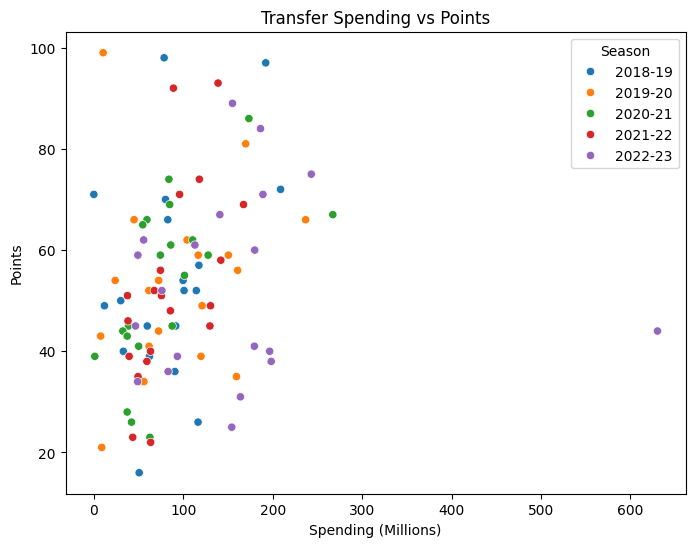

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(data=final, x="Spend_m", y="Points", hue="Season")
plt.title("Transfer Spending vs Points")
plt.xlabel("Spending (Millions)")
plt.ylabel("Points")
plt.show()

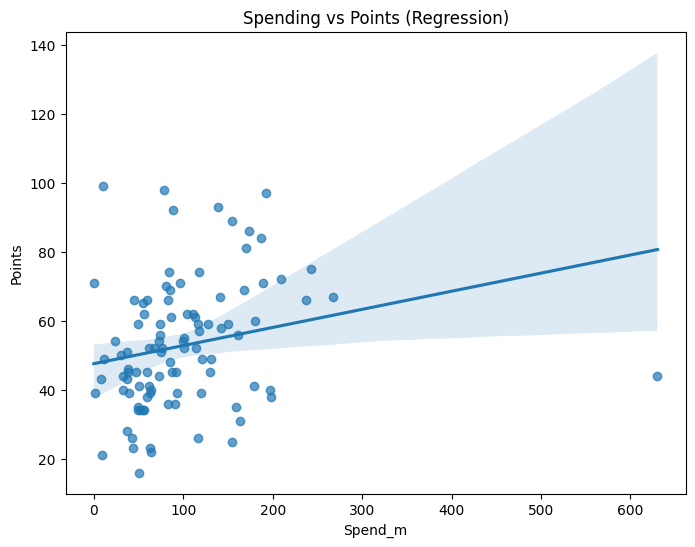

In [47]:
plt.figure(figsize=(8,6))
sns.regplot(data=final, x="Spend_m", y="Points", scatter_kws={"alpha":0.7})
plt.title("Spending vs Points (Regression)")
plt.show()

## 9. Regression Model: Predicting Points from Spending

In [48]:
model_df = final.dropna(subset=["Spend_m", "Points"]).copy()

X = model_df[["Spend_m"]]
y = model_df["Points"]

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(X, y)

preds = model.predict(X)

print("Rows used:", len(model_df))
print("R²:", r2_score(y, preds))
print("Coefficient (points per £1m):", model.coef_[0])
print("Intercept:", model.intercept_)

Rows used: 100
R²: 0.05074496438369891
Coefficient (points per £1m): 0.05246703305090913
Intercept: 47.54739961689367


### Regression Interpretation

The linear regression model produced an R² value of approximately 0.05.

This indicates that transfer spending explains only about 5% of the variation in league points.

While higher spending is weakly associated with improved performance, financial investment alone does not strongly determine league success.

This suggests that recruitment efficiency, tactical quality, squad cohesion, and player development likely play larger roles in determining competitive outcomes.

## 10. Spending Efficiency Analysis

### Raw Spending Efficiency (Points per £1m Spent)

This metric measures points earned relative to transfer expenditure.

Efficiency = Points / Spend_m

While intuitive, this ratio can be distorted when spending is very low,
as small denominators inflate the efficiency value.

This metric provides a basic view of financial efficiency but should be interpreted with caution.

In [54]:
final["Efficiency"] = final["Points"] / final["Spend_m"].replace(0, 1)

final.sort_values("Efficiency", ascending=False).head(15)

,Club,Games,Points,GoalDiff,GoalsFor,GoalsAgainst,Position,Season,Spend_m,Income_m,Net_Spend_m,Efficiency
3,Tottenham Hotspur,38,71,28,67,39,4,2018-19,0.00,5.35,5.35,71.000000
56,Burnley,38,39,-22,33,55,17,2020-21,1.10,2.30,1.20,35.454545
20,Liverpool,38,99,52,85,33,1,2019-20,10.40,48.00,37.60,9.519231
33,Crystal Palace,38,43,-19,31,50,14,2019-20,7.60,55.38,47.78,5.657895
11,Crystal Palace,38,49,-2,51,53,12,2018-19,11.85,350.00,-11.50,4.135021
39,Norwich City,38,21,-49,26,75,20,2019-20,8.82,2.20,-6.62,2.380952
29,Burnley,38,54,-7,43,50,10,2019-20,23.85,13.55,-10.30,2.264151
10,Watford,38,50,-7,52,59,11,2018-19,30.10,51.84,21.74,1.661130
23,Chelsea,38,66,15,69,54,4,2019-20,45.00,165.07,120.07,1.466667
53,Crystal Palace,38,44,-25,41,66,14,2020-21,32.40,20.00,-12.40,1.358025


### Regression-Based Overperformance

To account for distortions caused by very low spending,
we evaluate performance relative to model predictions.

Overperformance = Actual Points − Predicted Points

The predicted points are generated from a linear regression model using
transfer spending (and income) as explanatory variables.

Positive values indicate clubs that exceeded spending-based expectations.
Negative values indicate clubs that underperformed relative to financial investment.

This method provides a more robust measure of performance efficiency.

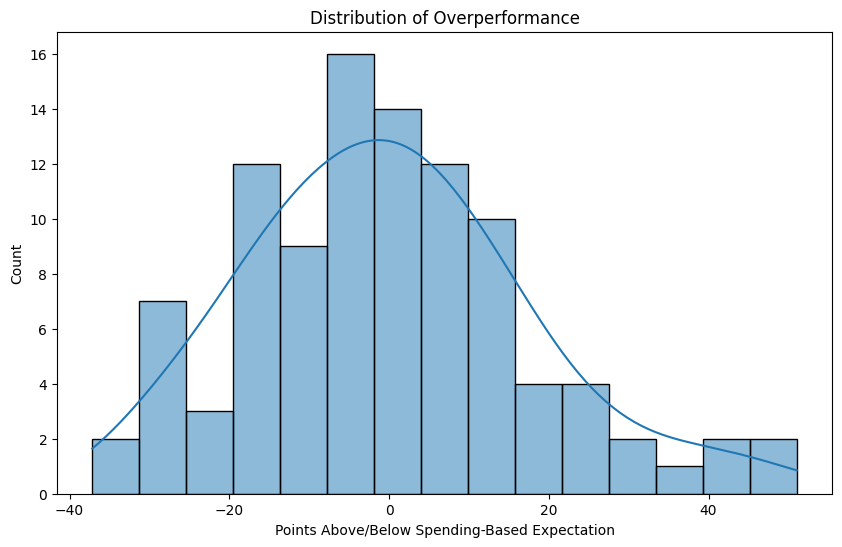

In [58]:
plt.figure(figsize=(10,6))
sns.histplot(final["Overperformance"], bins=15, kde=True)
plt.title("Distribution of Overperformance")
plt.xlabel("Points Above/Below Spending-Based Expectation")
plt.show()

In [57]:
final["Predicted_Points"] = model.predict(final[["Spend_m", "Income_m"]])
final["Overperformance"] = final["Points"] - final["Predicted_Points"]

final.sort_values("Overperformance", ascending=False).head(15)

,Club,Games,Points,GoalDiff,GoalsFor,GoalsAgainst,Position,Season,Spend_m,Income_m,Net_Spend_m,Efficiency,Predicted_Points,Overperformance
20,Liverpool,38,99,52,85,33,1,2019-20,10.40,48.00,37.60,4.852941,47.952100,51.047900
0,Manchester City,38,98,72,95,23,1,2018-19,78.59,57.60,-20.99,1.106220,51.739373,46.260627
61,Liverpool,38,92,68,94,26,2,2021-22,89.00,31.65,-57.35,0.929293,51.821954,40.178046
1,Liverpool,38,97,67,89,22,2,2018-19,192.20,41.32,-150.88,0.479723,57.465850,39.534150
60,Manchester City,38,93,73,99,26,1,2021-22,138.90,93.80,-45.10,0.624580,55.589893,37.410107
80,Manchester City,38,89,61,94,33,1,2022-23,155.00,162.17,7.17,0.539394,57.679039,31.320961
40,Manchester City,38,86,51,83,32,1,2020-21,173.40,64.00,-109.40,0.468920,56.879529,29.120471
81,Arsenal,38,84,45,88,43,2,2022-23,186.40,23.80,-162.60,0.427699,56.841769,27.158231
3,Tottenham Hotspur,38,71,28,67,39,4,2018-19,0.00,5.35,5.35,7.100000,46.629967,24.370033
21,Manchester City,38,81,67,102,35,2,2019-20,169.82,71.00,-98.82,0.450450,56.816345,24.183655


## 11. Conclusion

### Project Summary

This analysis evaluated whether transfer spending explains Premier League performance
across five seasons (2018–19 to 2022–23).

A linear regression model showed that transfer spending explains only ~5–6% of the variation in league points.

While spending is weakly positively correlated with performance,
financial investment alone is not a strong predictor of competitive success.

Regression-based overperformance analysis revealed that several clubs,
most notably Liverpool during 2019–20, significantly exceeded spending-based expectations.

These findings suggest that recruitment efficiency, tactical systems,
player development, and squad stability play a more critical role
than raw financial expenditure alone.

### Key Takeaways

- Spending has a weak positive relationship with performance.
- Net spending shows almost no relationship with points.
- Several elite seasons dramatically exceeded financial expectations.
- Strategic efficiency appears more important than absolute expenditure.